# Explain you opinion (P5)

In [1]:
!pip install bornrule

In [2]:
!pip install cupy-cuda11x

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 MB 4.5 MB/s eta 0:00:00


In [3]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.6 MB/s eta 0:00:00


In [6]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# PREPROCESSING LIBRARIES
import nltk
import re
import string
#Stopwords to remove from the text
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
#To tokenize words
from nltk.tokenize import word_tokenize
nltk.download('punkt')
#To lematize words
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
#Expand contractions
import contractions

#Libraries for the Classifier model
from bornrule import BornClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

#Library for syntax parsing
import spacy
from tqdm import tqdm
nlp = spacy.load('en_core_web_sm')

#Libraries for the LDA model
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel

#Models
import gensim
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
#Metrics for clustering
from sklearn.manifold import TSNE

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Download datasets

In [7]:
!pip install kaggle

In [ ]:
#Upload the kaggle.json file with the API key
from google.colab import files
files.upload()

In [9]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
import kaggle

In [11]:
!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis

Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
License(s): CC0-1.0
  0% 0.00/1.99M [00:00<?, ?B/s]
100% 1.99M/1.99M [00:00<00:00, 30.3MB/s]


In [12]:
!unzip '/content/twitter-entity-sentiment-analysis.zip'

Archive:  /content/twitter-entity-sentiment-analysis.zip
  inflating: twitter_training.csv    
  inflating: twitter_validation.csv  


In [13]:
columns = ['tweet_ID', 'entity', 'sentiment', 'content']
data1 = pd.read_csv('/content/twitter_training.csv', names=columns)
data2 = pd.read_csv('/content/twitter_validation.csv', names=columns)

In [14]:
data = pd.concat([data1, data2], ignore_index=True)

In [15]:
data

,tweet_ID,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
75677,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
75678,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
75679,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
75680,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [16]:
data['content'] = data['content'].astype(pd.StringDtype())
data['sentiment'] = data['sentiment'].astype(pd.StringDtype())
data['entity'] = data['entity'].astype(pd.StringDtype())

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_ID   75682 non-null  int64 
 1   entity     75682 non-null  string
 2   sentiment  75682 non-null  string
 3   content    74996 non-null  string
dtypes: int64(1), string(3)
memory usage: 2.3 MB


In [18]:
len(data)

75682

In [19]:
data = data.dropna(ignore_index=True)

In [20]:
len(data)

74996

In [21]:
data = data[data['sentiment'] != 'Irrelevant']
data

,tweet_ID,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74989,314,Amazon,Negative,Please explain how this is possible! How can t...
74990,9701,PlayStation5(PS5),Positive,Good on Sony. As much as I want to see the new...
74993,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
74994,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [22]:
data = data.drop_duplicates(ignore_index=True)
data

,tweet_ID,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
59510,1373,Battlefield,Negative,I have noticed streamers I watch who are now p...
59511,10588,RedDeadRedemption(RDR),Neutral,@6th__man playing red dead redemption- “Oh sh...
59512,7516,LeagueOfLegends,Neutral,♥️ Suikoden 2 1️⃣ Alex Kidd in Miracle World 😢...
59513,5708,HomeDepot,Positive,Thank you to Matching funds Home Depot RW paym...


## Exploring the datasets

In [23]:
# Compute the categories distributions for the dataset
entities = data.groupby('entity').size().reset_index(name='count')
entities

,entity,count
0,Amazon,2082
1,ApexLegends,2117
2,AssassinsCreed,1914
3,Battlefield,1357
4,Borderlands,1983
5,CS-GO,1586
6,CallOfDuty,1665
7,CallOfDutyBlackopsColdWar,1708
8,Cyberpunk2077,1727
9,Dota2,1839


In [24]:
# Compute the sentiment distributions for the dataset
data_sentiment = data['sentiment'].value_counts()
data_sentiment

sentiment
Negative    21790
Positive    19846
Neutral     17879
Name: count, dtype: Int64

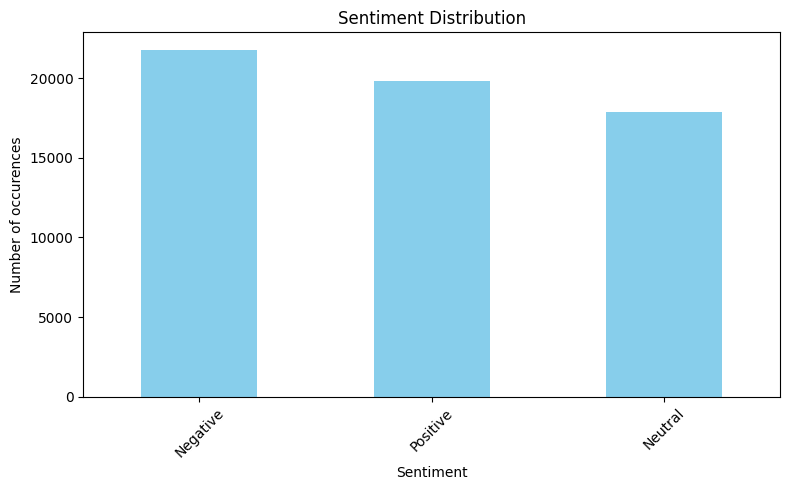

In [25]:
plt.figure(figsize=(8, 5))
data_sentiment.plot(kind='bar', color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of occurences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Data pre-processing

In [26]:
MAX_WORD_LENGTH = 15

# Pre-processing functions
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)

def remove_mentions(text):
    return re.sub(r'@\w+', ' ', text)

def remove_hashtags(text):
    return re.sub(r'#\w+', ' ', text)

def is_text_ascii(text):
    return all(ord(char) < 128 for char in text)

def is_alpha_word(word):
    return word.isalpha()

def expand_contractions(text):
    return contractions.fix(text)

def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

def preprocess_tweet(tweet):
    tweet = remove_urls(tweet)
    tweet = remove_mentions(tweet)
    tweet = remove_hashtags(tweet)

    if not is_text_ascii(tweet):
        return ""

    tweet = tweet.lower()
    tweet = expand_contractions(tweet)
    tweet = remove_special_characters(tweet)

    tokens = word_tokenize(tweet)

    lemmatizer = WordNetLemmatizer()

    tokens = [word for word in tokens if is_alpha_word(word)]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    tokens = [word for word in tokens if len(word) <= MAX_WORD_LENGTH]

    return ' '.join(tokens)

In [ ]:
data.loc[:, "text"]= data["content"].apply(preprocess_tweet)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59515 entries, 0 to 59514
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_ID   59515 non-null  int64 
 1   entity     59515 non-null  string
 2   sentiment  59515 non-null  string
 3   content    59515 non-null  string
 4   text       59515 non-null  object
dtypes: int64(1), object(1), string(3)
memory usage: 2.3+ MB


In [ ]:
data["text"] = data['text'].astype(pd.StringDtype())

In [30]:
data = data[data.apply(lambda row: row.astype(str).str.strip() != '').all(axis=1)]

In [31]:
data = data.dropna(ignore_index=True)

In [32]:
data

,tweet_ID,entity,sentiment,content,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,getting borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,getting borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,coming borderland murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,getting borderland murder
...,...,...,...,...,...
48490,201,Amazon,Neutral,Across the Fourwinds is the first book of the ...,across fourwinds first book maidstone chronicl...
48491,1264,Battlefield,Positive,I started getting back into playing Battlefiel...,started getting back playing battlefield hardl...
48492,2734,Borderlands,Positive,surprise i still love #borderlands ' jack pic....,surprise still love jack
48493,4444,Google,Neutral,This is....odd. @Google suggests the most dead...,isodd suggests deadly terrorst attack committe...


## Sentiment analysis classification with Born Classifier

Perform a sentiment analysis classification of documents using Born

In [33]:
vec = CountVectorizer(tokenizer=word_tokenize, lowercase=True, token_pattern=None)
X = vec.fit_transform(data['text'])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, data['sentiment'], test_size=0.2, random_state=42)

In [35]:
# Initialize the BornClassifier
born_classifier = BornClassifier()

# Fit the classifier to the training data
born_classifier.fit(X_train, y_train)

BornClassifier()

In [36]:
print(X_train.shape, X_test.shape)

(38796, 25132) (9699, 25132)


In [37]:
born_predictions = born_classifier.predict(X_test)
born_accuracy = accuracy_score(y_test, born_predictions)
print(f"Born Accuracy: {born_accuracy}")

Born Accuracy: 0.7702855964532426


In [39]:
# Evaluate the classifier
print(classification_report(y_test, born_predictions))

              precision    recall  f1-score   support

    Negative       0.78      0.83      0.81      3669
     Neutral       0.77      0.63      0.69      2693
    Positive       0.76      0.82      0.79      3337

    accuracy                           0.77      9699
   macro avg       0.77      0.76      0.76      9699
weighted avg       0.77      0.77      0.77      9699



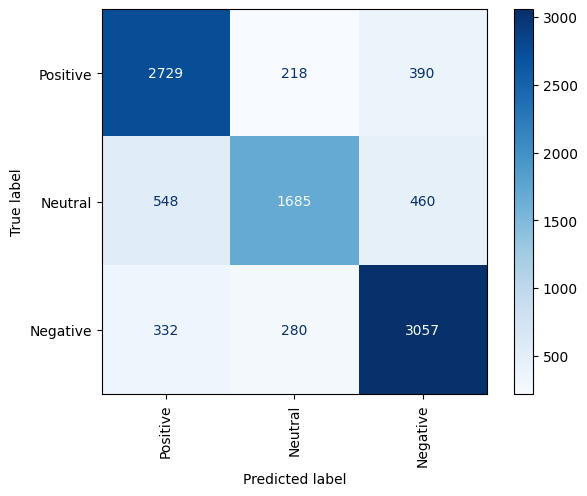

In [40]:
matrix = confusion_matrix(y_test, born_predictions, labels=data['sentiment'].unique())

fig, ax = plt.subplots(figsize=(7, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=data['sentiment'].unique())
disp.plot(ax=ax, cmap='Blues')
ax.xaxis.set_tick_params(rotation=90)

plt.show()

## Explanation features

Extract the explanation features for each pair of documents and predicted labels

In [41]:
# Get explanations from the Born Classifier
explanations = born_classifier.explain()
# Create a reverse mapping for vectorized features
feature_names = vec.get_feature_names_out()

In [42]:
sentiment = data.groupby('sentiment').size().reset_index(name='count')
sentiment

,sentiment,count
0,Negative,17955
1,Neutral,13737
2,Positive,16803


In [43]:
explanation_features = pd.DataFrame(explanations.toarray(), index=feature_names, columns=sentiment['sentiment'])
explanation_features

sentiment,Negative,Neutral,Positive
aa,0.005390,0.0,0.000000
aaa,0.001904,0.0,0.002159
aaaaaaaaaaaa,0.000000,0.0,0.003518
aaaaaaaaaaaaa,0.000000,0.0,0.004975
aaaaaaaaaaages,0.000000,0.0,0.004623
...,...,...,...
zyotflen,0.000000,0.0,0.003047
zywzswpxq,0.002523,0.0,0.000000
zzgixvkt,0.004518,0.0,0.000000
zzvfsrhewg,0.002160,0.0,0.000000


In [44]:
explanation_features.columns.name = None

In [45]:
explanation_features = explanation_features[(explanation_features['Negative'] > 0) | (explanation_features['Neutral'] > 0) | (explanation_features['Positive'] > 0)]
len(explanation_features)

23294

In [46]:
threshold_neutral = np.percentile(explanation_features['Neutral'], 80)
threshold_negative = np.percentile(explanation_features['Negative'], 80)
threshold_positive = np.percentile(explanation_features['Positive'], 80)

In [47]:
explanation_features = explanation_features[ (explanation_features['Neutral'] >= threshold_neutral) | (explanation_features['Negative'] >= threshold_negative) | (explanation_features['Positive'] >= threshold_positive)]

In [48]:
explanation_features['Positive'].sort_values(ascending=False).head(15)

love         0.044679
nice         0.036413
dope         0.034889
excited      0.034008
wait         0.033493
beautiful    0.030758
fun          0.030463
wow          0.030312
thank        0.029645
tuning       0.025124
amazing      0.023469
best         0.023231
awesome      0.020946
good         0.020028
assassin     0.019978
Name: Positive, dtype: float64

In [49]:
explanation_features['Negative'].sort_values(ascending=False).head(15)

fix            0.056442
fuck           0.040436
server         0.034199
suck           0.030557
trash          0.026053
wtf            0.024024
glitch         0.023769
eamaddennfl    0.023463
broken         0.022154
shit           0.021913
greedy         0.021247
disrespect     0.020279
unplayable     0.020253
joke           0.019913
matchmaking    0.019486
Name: Negative, dtype: float64

In [50]:
explanation_features['Neutral'].sort_values(ascending=False).head(15)

earned         0.049268
check          0.037362
achievement    0.027844
horrific       0.025757
vision         0.022568
beep           0.021975
love           0.021012
orgrimmar      0.020387
summoners      0.019810
panic          0.019745
video          0.019064
godrays        0.019031
arcstar        0.018221
johnson        0.017942
hulk           0.017022
Name: Neutral, dtype: float64

In [51]:
features = explanation_features.reset_index()

In [52]:
features.rename(columns={'index': 'word'}, inplace=True)

In [53]:
features['word'] = features['word'].astype(pd.StringDtype())

In [54]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13055 entries, 0 to 13054
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   word      13055 non-null  string 
 1   Negative  13055 non-null  float64
 2   Neutral   13055 non-null  float64
 3   Positive  13055 non-null  float64
dtypes: float64(3), string(1)
memory usage: 408.1 KB


In [55]:
list_feature = list(features.word)

## 1. Computing the candidate aspects: Syntax Based approach

In [56]:
def extract_aspects_and_sentences(text):
    doc = nlp(text)
    aspect_sentences = set()
    processed_aspects = set()

    for sent in doc.sents:
        for token in sent:
            aspect = None
            aspect_segment = []
            if token.dep_ == 'amod' and token.head.pos_ == 'NOUN':
                aspect = token.head.text
                aspect_segment.append(token.head)
                aspect_segment.append(token)
            elif token.dep_ == 'nsubj' and token.head.pos_ == 'VERB':
                aspect = token.text
                aspect_segment.append(token)
                for child in token.head.children:
                    if child.dep_ == 'dobj':
                        aspect_segment.append(child)

            if aspect:
                aspect_start = min([t.idx for t in aspect_segment])
                aspect_end = max([t.idx + len(t.text) for t in aspect_segment])

                if aspect_end - aspect_start <= len(aspect) + 1:
                    aspect_sentence = sent.text.strip()
                else:
                    aspect_sentence = sent.text[aspect_start:aspect_end].strip()

                if aspect not in processed_aspects:
                    aspect_sentences.add((aspect, aspect_sentence))
                    processed_aspects.add(aspect)

    return list(aspect_sentences)

In [57]:
aspect_sentences = extract_aspects_and_sentences(data['text'][565])
aspect_sentences

[('fix', 'big hot fix'), ('system', 'whole factory reset system')]

In [58]:
def find_aspect_sent(aspect):
  if aspect in explanation_features.index:
    row = explanation_features.loc[aspect]
    max_value = row.max()
    max_column = row.idxmax()
    return max_column

In [59]:
aspect_df = []

for i, row in tqdm(data.iterrows(), total=data.shape[0]):
    tweet_id = row['tweet_ID']
    entity = row['entity']
    sentiment = row['sentiment']
    text = row['text']

    aspect_sentences = extract_aspects_and_sentences(text)

    for aspect, sentence in aspect_sentences:
        if aspect in list_feature:
          aspect_sent = find_aspect_sent(aspect)
          aspect_df.append((tweet_id, entity, aspect, sentence, sentiment, aspect_sent))

aspect_data = pd.DataFrame(aspect_df, columns=['id', 'entity', 'aspect', 'sentence', 'sentiment', 'aspect_sent'])

100%|██████████| 48495/48495 [09:13<00:00, 87.55it/s]


In [61]:
aspect_data = aspect_data.drop_duplicates(ignore_index=True)
aspect_data

,id,entity,aspect,sentence,sentiment,aspect_sent
0,2401,Borderlands,kill,coming border kill,Positive,Neutral
1,2401,Borderlands,borderland,getting borderland kill,Positive,Positive
2,2402,Borderlands,fun,fun know huge fan maya,Positive,Positive
3,2402,Borderlands,fun,spent hour making something fun know huge rhan...,Positive,Positive
4,2403,Borderlands,varlope,la varlope,Neutral,Neutral
...,...,...,...,...,...,...
26136,9548,Overwatch,march,chinese fan sad learn match china february mar...,Neutral,Neutral
26137,1498,Battlefield,information,actual information,Negative,Negative
26138,10889,TomClancysGhostRecon,update,immersive update,Negative,Negative
26139,11363,TomClancysRainbowSix,fortress,chalet fortress,Positive,Positive


In [62]:
aspect_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26141 entries, 0 to 26140
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           26141 non-null  int64 
 1   entity       26141 non-null  object
 2   aspect       26141 non-null  object
 3   sentence     26141 non-null  object
 4   sentiment    26141 non-null  object
 5   aspect_sent  26141 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.2+ MB


In [ ]:
aspect_data['aspect_sent'], aspect_data['sentence'] = aspect_data['aspect_sent'].astype(pd.StringDtype()),aspect_data['sentence'].astype(pd.StringDtype())

In [64]:
a = aspect_data.groupby(['entity','aspect']).size().reset_index(name='count')

In [65]:
a = a[ (a['count'] >= np.percentile(a['count'], 75))]

In [66]:
a.sort_values(by='count', ascending=False).head(15)

,entity,aspect,count
9046,johnson&johnson,johnson,394
7269,RedDeadRedemption(RDR),redemption,264
8,Amazon,amazon,229
1115,Borderlands,borderland,175
3077,Facebook,facebook,163
7817,TomClancysRainbowSix,game,151
7149,RedDeadRedemption(RDR),game,148
2813,FIFA,fifa,146
5148,MaddenNFL,eamaddennfl,144
8695,WorldOfCraft,warcraft,133


#### Predict the sentiment

Predict the sentiment for the sentence or text portion using the trained Born classifier

In [67]:
X = vec.transform(aspect_data['sentence'])

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, aspect_data['aspect_sent'], test_size=0.2, random_state=42)

In [69]:
print(X_train.shape, X_test.shape)

(20912, 25132) (5229, 25132)


In [70]:
born_predictions = born_classifier.predict(X_test)
born_accuracy = accuracy_score(y_test, born_predictions)
print(f"Born Accuracy: {born_accuracy}")

Born Accuracy: 0.7580799388028304


In [71]:
# Evaluate the classifier
print(classification_report(y_test, born_predictions))

              precision    recall  f1-score   support

    Negative       0.82      0.77      0.79      2221
     Neutral       0.79      0.73      0.76      1684
    Positive       0.65      0.78      0.71      1324

    accuracy                           0.76      5229
   macro avg       0.75      0.76      0.75      5229
weighted avg       0.77      0.76      0.76      5229



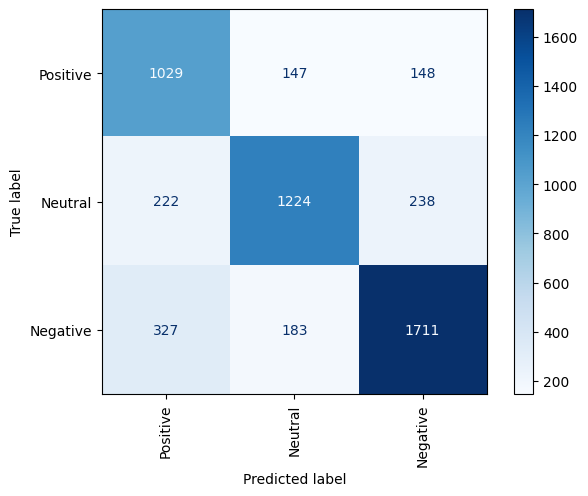

In [72]:
matrix = confusion_matrix(y_test, born_predictions, labels=data['sentiment'].unique())

fig, ax = plt.subplots(figsize=(7, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=data['sentiment'].unique())
disp.plot(ax=ax, cmap='Blues')
ax.xaxis.set_tick_params(rotation=90)

plt.show()

## 2. Computing the candidate aspects: LDA model approach

In [73]:
# Preprocess function to tokenized
def preprocess(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and not token.is_punct and token.lemma_ not in stop_words and token.pos_ == 'NOUN']
    return tokens

In [ ]:
sentence = pd.DataFrame(data)

In [ ]:
dic = features['word'].apply(lambda x: word_tokenize(x))
sentence['token'] = sentence['text'].apply(preprocess)

In [ ]:
#Create the dictionary and the corpus
dictionary = Dictionary(dic)
corpus = [dictionary.doc2bow(text) for text in sentence['token']]

In [ ]:
#Fit the LDA model
num_topics = 32  # Number of categories
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

In [ ]:
# Function to assign topics to documents
def get_document_topics(text):
    bow = dictionary.doc2bow(text)
    topics = lda_model.get_document_topics(bow)
    return topics

In [ ]:
sentence['topics'] = sentence['token'].apply(get_document_topics)

In [ ]:
# Extract sentences and associate them to the topics
def extract_aspects_and_sentences(row):
    text = row['text']
    doc = nlp(text)
    topics = lda_model.get_document_topics(dictionary.doc2bow(row['token']), minimum_probability=0.1)
    aspect_sentences = defaultdict(list)

    for topic_id, prob in topics:
        aspect = lda_model.show_topic(topic_id, topn=1)[0][0]

    for sent in doc.sents:
        sent_text = sent.text.strip()
        for topic_id, prob in topics:
            aspect = lda_model.show_topic(topic_id, topn=1)[0][0]
            if aspect in sent_text and all(aspect not in s for s in aspect_sentences[aspect]):
                aspect_sentences[aspect].append(sent_text)

    result = []
    for aspect, sentences in aspect_sentences.items():
        if sentences:
            for sentence in sentences:
              aspect_sent = find_aspect_sent(aspect)
              result.append((row['tweet_ID'], row['entity'], aspect, sentence, row['sentiment'], aspect_sent))

    return result

In [ ]:
aspect_df = []

for i, row in tqdm(sentence.iterrows(), total=sentence.shape[0]):
    aspect_df.extend(extract_aspects_and_sentences(row))

aspect_data = pd.DataFrame(aspect_df, columns=['id', 'entity', 'aspect', 'sentence', 'sentiment', 'aspect_sent'])

100%|██████████| 48495/48495 [08:59<00:00, 89.84it/s]


In [ ]:
aspect_data = aspect_data.drop_duplicates(ignore_index=True)
aspect_data

,id,entity,aspect,sentence,sentiment,aspect_sent
0,2402,Borderlands,fun,spent hour making something fun know huge fan ...,Positive,Positive
1,2402,Borderlands,fun,spent couple hour something fun know huge bord...,Positive,Positive
2,2402,Borderlands,fun,spent hour something fun know huge borderland ...,Positive,Positive
3,2402,Borderlands,fun,spent hour making something fun know huge rhan...,Positive,Positive
4,2405,Borderlands,fuck,biggest dissappoinment life came year ago fuck...,Negative,Negative
...,...,...,...,...,...,...
19630,7617,MaddenNFL,game,make cross play thing next madden also gift se...,Negative,Negative
19631,10889,TomClancysGhostRecon,update,welp immersive update got delayed later next m...,Negative,Negative
19632,5532,Hearthstone,tonight,thanks watching play tonight thanks getting gi...,Positive,Positive
19633,5532,Hearthstone,thank,thanks watching play tonight thanks getting gi...,Positive,Positive


In [ ]:
aspect_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19635 entries, 0 to 19634
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           19635 non-null  int64 
 1   entity       19635 non-null  object
 2   aspect       19635 non-null  object
 3   sentence     19635 non-null  object
 4   sentiment    19635 non-null  object
 5   aspect_sent  19635 non-null  object
dtypes: int64(1), object(5)
memory usage: 920.5+ KB


In [ ]:
aspect_data['aspect_sent'], aspect_data['sentence'] = aspect_data['aspect_sent'].astype(pd.StringDtype()),aspect_data['sentence'].astype(pd.StringDtype())

In [ ]:
a = aspect_data.groupby(['aspect']).size().reset_index(name='count')

In [ ]:
a.sort_values(by='count', ascending=False).head(15)

,aspect,count
8,game,5733
22,shit,1213
14,love,1094
26,thank,972
6,fuck,890
30,video,867
7,fun,787
31,world,729
17,problem,591
5,fix,553


### Predict the sentiment

Predict the sentiment for the sentence or text portion using the trained Born classifier

In [ ]:
X = vec.transform(aspect_data['sentence'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, aspect_data['aspect_sent'], test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape)

(15708, 25132) (3927, 25132)


In [ ]:
born_predictions = born_classifier.predict(X_test)
born_accuracy = accuracy_score(y_test, born_predictions)
print(f"Born Accuracy: {born_accuracy}")

Born Accuracy: 0.6577540106951871


In [ ]:
# Evaluate the classifier
print(classification_report(y_test, born_predictions))

              precision    recall  f1-score   support

    Negative       0.87      0.66      0.75      2454
     Neutral       0.42      0.51      0.46       498
    Positive       0.48      0.73      0.58       975

    accuracy                           0.66      3927
   macro avg       0.59      0.63      0.60      3927
weighted avg       0.72      0.66      0.67      3927



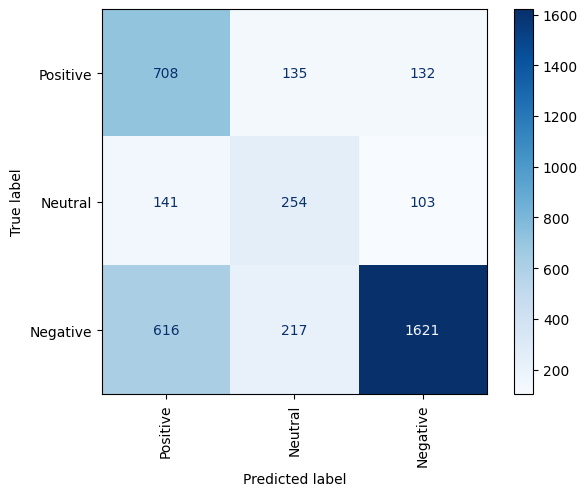

In [ ]:
matrix = confusion_matrix(y_test, born_predictions, labels=data['sentiment'].unique())

fig, ax = plt.subplots(figsize=(7, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=data['sentiment'].unique())
disp.plot(ax=ax, cmap='Blues')
ax.xaxis.set_tick_params(rotation=90)

plt.show()

## 3. Computing the candidate aspects: Word2Vec

In [74]:
# Tokenized documents
tokenized_docs = [preprocess(doc) for doc in data['content']]

Word2Vec model

In [75]:
# Fit Word2Vec model
model = Word2Vec(sentences=tokenized_docs, vector_size=100, window=5, min_count=1, workers=4)

 Associate each aspect to a specific sentence or portion of the text

In [90]:
def extract_aspects(text, aspects):
    doc = nlp(text)
    aspect_sentences = {aspect: [] for aspect in aspects}

    for sent in doc.sents:
        for aspect in aspects:
            if aspect in sent.text:
                # Dependency parsing to find the syntactic relation between aspect and sentence
                for token in sent:
                    if token.text == aspect:
                        subtree_span = doc[token.left_edge.i : token.right_edge.i + 1]
                        aspect_sentence = subtree_span.text.strip()

                        if len(aspect_sentence.split()) != 1:
                            aspect_sentences[aspect].append(aspect_sentence)

    return aspect_sentences

In [91]:
aspect_df = []

for i, row in tqdm(data.iterrows(), total=data.shape[0]):
    tweet_id = row['tweet_ID']
    entity = row['entity']
    sentiment = row['sentiment']
    text = row['text']

    aspects = [feature for feature in list_feature if feature in model.wv]
    aspect_sentences = extract_aspects(text, aspects)

    for aspect, sentences in aspect_sentences.items():
        if sentences:
            for sentence in sentences:
                aspect_sent = find_aspect_sent(aspect)
                aspect_df.append((tweet_id, entity, aspect, sentence, sentiment, aspect_sent))

aspect_data = pd.DataFrame(aspect_df, columns=['id', 'entity', 'aspect', 'sentence', 'sentiment', 'aspect_sent'])

100%|██████████| 48495/48495 [45:54<00:00, 17.60it/s]


In [92]:
aspect_data = aspect_data.drop_duplicates(ignore_index=True)
aspect_data

,id,entity,aspect,sentence,sentiment,aspect_sent
0,2401,Borderlands,kill,coming border kill,Positive,Neutral
1,2401,Borderlands,kill,borderland kill,Positive,Neutral
2,2402,Borderlands,fun,fun know huge borderland fan maya,Positive,Positive
3,2403,Borderlands,borderland,rare powerful handsome jackpot borderland,Neutral,Positive
4,2403,Borderlands,borderland,handsome jackpot borderland,Neutral,Positive
...,...,...,...,...,...,...
55760,11869,Verizon,collect,collect usage power quality data,Neutral,Neutral
55761,201,Amazon,amazon,journey amazon,Neutral,Neutral
55762,201,Amazon,book,first book,Neutral,Neutral
55763,201,Amazon,reviewer,wondrous journey amazon reviewer,Neutral,Neutral


In [93]:
aspect_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55765 entries, 0 to 55764
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           55765 non-null  int64 
 1   entity       55765 non-null  object
 2   aspect       55765 non-null  object
 3   sentence     55765 non-null  object
 4   sentiment    55765 non-null  object
 5   aspect_sent  55765 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.6+ MB


In [94]:
aspect_data['aspect_sent'], aspect_data['sentence'] = aspect_data['aspect_sent'].astype(pd.StringDtype()),aspect_data['sentence'].astype(pd.StringDtype())

In [95]:
a = aspect_data.groupby(['entity','aspect']).size().reset_index(name='count')

In [96]:
a = a[ (a['count'] >= np.percentile(a['count'], 75))]

In [97]:
a.sort_values(by='count', ascending=False).head(15)

,entity,aspect,count
1513,Borderlands,borderland,392
4014,Facebook,facebook,359
9374,RedDeadRedemption(RDR),redemption,338
3653,FIFA,fifa,309
9,Amazon,amazon,302
8368,Overwatch,overwatch,300
11149,WorldOfCraft,warcraft,292
10049,TomClancysRainbowSix,game,256
9241,RedDeadRedemption(RDR),game,230
896,AssassinsCreed,creed,219


### Predict the sentiment

Predict the sentiment for the sentence or text portion using the trained Born classifier

In [98]:
X = vec.transform(aspect_data['sentence'])

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, aspect_data['aspect_sent'], test_size=0.2, random_state=42)

In [100]:
print(X_train.shape, X_test.shape)

(44612, 25132) (11153, 25132)


In [101]:
born_predictions = born_classifier.predict(X_test)
born_accuracy = accuracy_score(y_test, born_predictions)
print(f"Born Accuracy: {born_accuracy}")

Born Accuracy: 0.7593472608266834


In [102]:
# Evaluate the classifier
print(classification_report(y_test, born_predictions))

              precision    recall  f1-score   support

    Negative       0.82      0.77      0.80      4913
     Neutral       0.73      0.72      0.73      2842
    Positive       0.70      0.78      0.74      3398

    accuracy                           0.76     11153
   macro avg       0.75      0.76      0.75     11153
weighted avg       0.76      0.76      0.76     11153



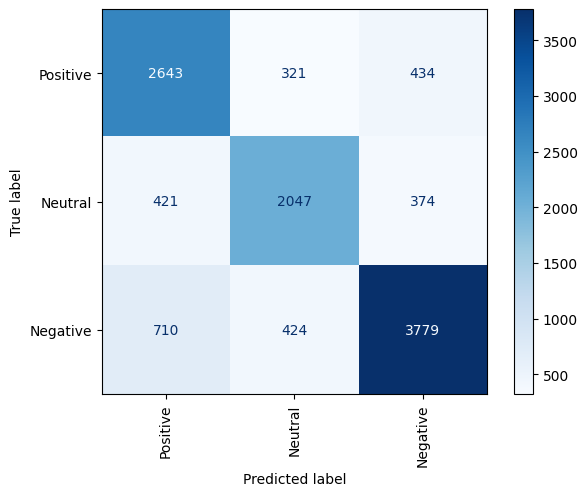

In [103]:
matrix = confusion_matrix(y_test, born_predictions, labels=data['sentiment'].unique())

fig, ax = plt.subplots(figsize=(7, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=data['sentiment'].unique())
disp.plot(ax=ax, cmap='Blues')
ax.xaxis.set_tick_params(rotation=90)

plt.show()

##  4. Computing the candidate aspects: Word2Vec and K-means clustering

In [104]:
feature_vectors = [model.wv[feature] for feature in list_feature if feature in model.wv]

In [105]:
# KMeans
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(feature_vectors)

# Clusters with words
clusters = {i: [] for i in range(num_clusters)}
for i, label in enumerate(kmeans.labels_):
    clusters[label].append(list_feature[i])

In [106]:
for cluster_id, features in clusters.items():
    print(f"Cluster {cluster_id}: {features}")

Cluster 0: ['aa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaages', 'aahqxwcz', 'aajtak', 'aall', 'aarogya', 'aaronrodgers', 'aazrytu', 'abandon', 'abandoned', 'abandoning', 'abbott', 'abbxvg', 'abcnewsarea', 'abcnewsbayarea', 'abeewdsndvh', 'abella', 'abnormal', 'abnormality', 'aboard', 'abolished', 'abominable', 'abot', 'aboutperfection', 'absolute', 'absolution', 'abstergo', 'abstract', 'abuse', 'abused', 'abusive', 'abysmal', 'ac', 'acc', 'accally', 'accelerated', 'accelerator', 'acceptable', 'accepting', 'accessory', 'accident', 'accidental', 'acckfcpzs', 'acclaimed', 'acclimatization', 'accomplishment', 'according', 'account', 'accountability', 'accountable', 'accountant', 'accounted', 'accounting', 'accountmy', 'accountunk', 'accuchek', 'accuracy', 'accurate', 'accuses', 'accusing', 'ace', 'acer', 'achieve', 'achieved', 'achievement', 'achievementland', 'achieving', 'achievs', 'acid', 'ackshully', 'acne', 'acolyte', 'acorto', 'acquires', 'acquisition', 'acronym', 'actical', 'ac

In [107]:
# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, perplexity=50, n_iter=300)
tsne_result = tsne.fit_transform(np.array(feature_vectors))

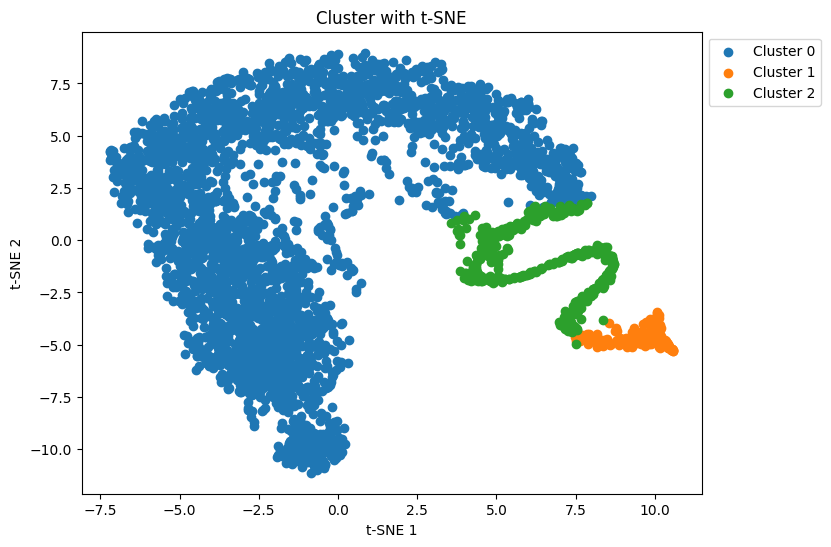

In [108]:
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    points = tsne_result[np.where(kmeans.labels_ == i)]
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}')
plt.title('Cluster with t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

 Associate each aspect to a specific sentence or portion of the text

In [115]:
def extract_aspects(text, aspects):
    doc = nlp(text)
    aspect_sentences = {aspect: [] for id, aspect in aspects}

    for sent in doc.sents:
        for id, aspect in aspects:
            if aspect in sent.text:
                for token in sent:
                    if token.text == aspect:
                        subtree_span = doc[token.left_edge.i : token.right_edge.i + 1]
                        aspect_sentence = subtree_span.text.strip()

                        if len(aspect_sentence.split()) != 1:
                            aspect_sentences[aspect].append(aspect_sentence)

    return aspect_sentences

In [117]:
aspect_df = []

for i, row in tqdm(data.iterrows(), total=data.shape[0]):
    id = row['tweet_ID']
    entity = row['entity']
    sentiment = row['sentiment']
    text = row['text']

    aspects = [(id, feature) for (id, cluster) in clusters.items() for feature in cluster]
    aspect_sentences = extract_aspects(text, aspects)

    for aspect, sentences in aspect_sentences.items():
        if sentences:
            for sentence in sentences:
              aspect_sent = find_aspect_sent(aspect)
              aspect_df.append((id, entity, aspect, sentence, sentiment, aspect_sent ))

aspect_data = pd.DataFrame(aspect_df, columns=['id', 'entity', 'aspect', 'sentence', 'sentiment', 'aspect_sent'])

100%|██████████| 48495/48495 [37:14<00:00, 21.70it/s]


In [118]:
aspect_data = aspect_data.drop_duplicates(ignore_index=True)
aspect_data

,id,entity,aspect,sentence,sentiment,aspect_sent
0,2403,Borderlands,borderland,rare powerful handsome jackpot borderland,Neutral,Positive
1,2403,Borderlands,dlvritrmtrgf,rare powerful handsome jackpot borderland xbox...,Neutral,Neutral
2,2403,Borderlands,borderland,handsome jackpot borderland,Neutral,Positive
3,2403,Borderlands,dlvrit,handsome jackpot borderland xbox dlvrit,Neutral,Neutral
4,2403,Borderlands,dfrit,handsome jackpot borderland xbox dfrit,Neutral,Neutral
...,...,...,...,...,...,...
22571,9548,Overwatch,china,chinese fan sad learn match china,Neutral,Neutral
22572,10889,TomClancysGhostRecon,delayed,welp immersive update got delayed later next m...,Negative,Neutral
22573,11869,Verizon,collect,collect usage power quality data,Neutral,Neutral
22574,201,Amazon,book,first book,Neutral,Neutral


In [119]:
aspect_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22576 entries, 0 to 22575
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           22576 non-null  int64 
 1   entity       22576 non-null  object
 2   aspect       22576 non-null  object
 3   sentence     22576 non-null  object
 4   sentiment    22576 non-null  object
 5   aspect_sent  22576 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.0+ MB


In [120]:
aspect_data['aspect_sent'], aspect_data['sentence'] = aspect_data['aspect_sent'].astype(pd.StringDtype()),aspect_data['sentence'].astype(pd.StringDtype())

In [121]:
a = aspect_data.groupby(['entity','aspect']).size().reset_index(name='count')

In [122]:
a = a[ (a['count'] >= np.percentile(a['count'], 75))]

In [123]:
a.sort_values(by='count', ascending=False).head(15)

,entity,aspect,count
980,Borderlands,borderland,392
2519,Facebook,facebook,359
2270,FIFA,fifa,309
20,Amazon,amazon,302
647,AssassinsCreed,creed,219
6598,WorldOfCraft,earned,200
6372,WorldOfCraft,achievement,118
301,ApexLegends,apex,114
5282,PlayerUnknownsBattlegrounds(PUBG),banned,111
5281,PlayerUnknownsBattlegrounds(PUBG),ban,109


### Predict the sentiment

Predict the sentiment for the sentence or text portion using the trained Born classifier

In [124]:
X = vec.transform(aspect_data['sentence'])

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, aspect_data['aspect_sent'], test_size=0.2, random_state=42)

In [126]:
print(X_train.shape, X_test.shape)

(18060, 25132) (4516, 25132)


In [127]:
born_predictions = born_classifier.predict(X_test)
born_accuracy = accuracy_score(y_test, born_predictions)
print(f"Born Accuracy: {born_accuracy}")

Born Accuracy: 0.8011514614703277


In [128]:
# Evaluate the classifier
print(classification_report(y_test, born_predictions))

              precision    recall  f1-score   support

    Negative       0.82      0.82      0.82      1745
     Neutral       0.80      0.77      0.79      1467
    Positive       0.77      0.82      0.79      1304

    accuracy                           0.80      4516
   macro avg       0.80      0.80      0.80      4516
weighted avg       0.80      0.80      0.80      4516



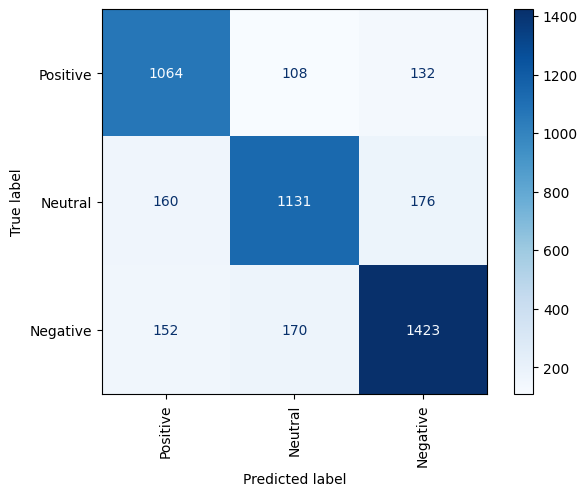

In [129]:
matrix = confusion_matrix(y_test, born_predictions, labels=data['sentiment'].unique())

fig, ax = plt.subplots(figsize=(7, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=data['sentiment'].unique())
disp.plot(ax=ax, cmap='Blues')
ax.xaxis.set_tick_params(rotation=90)

plt.show()